# Klasyfikacja gwiazd

#### Autorzy: Filip Sosnowski, Kacper Chabowski

Projekt ten polega na przeprowadzeniu analizy eksploracyjnej oraz klasyfikacji typów gwiazd na podstawie przygotowanego [zbioru danych](https://www.kaggle.com/datasets/deepu1109/star-dataset).
<br>Ten zbiór danych został wstępnie zbadany. Następnie przeprowadziliśmy klasyfikację - określiliśmy przynależności obiektów opisanych wektorem cech do jednej ze spredefiniowanych klas, czyli typu gwiazdy.

Do klasyfikacji wykorzystaliśmy:


1. Metodę najbliższego sąsiada
2. Metodę k-najbliższych sąsiadów
3. Metodę nabliższego protypu
4. Naiwny klasyfikator Bayesa
5. Drzewo decyzyjne

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import tree

In [3]:
#wgranie zbioru danych z naszego 'workspace'

data = pd.read_csv('data/starDataset.csv')

In [4]:
data.head(10)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M
5,2840,0.000650,0.1100,16.98,0,Red,M
6,2637,0.000730,0.1270,17.22,0,Red,M
7,2600,0.000400,0.0960,17.40,0,Red,M
8,2650,0.000690,0.1100,17.45,0,Red,M
9,2700,0.000180,0.1300,16.05,0,Red,M


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


In [6]:
#podstawowe informacje o każdym z atrybutów ilościowych
data[['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']].describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
count,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396
std,9552.425037,179432.244940,517.155763,10.532512
min,1939.000000,0.000080,0.008400,-11.920000
25%,3344.250000,0.000865,0.102750,-6.232500
50%,5776.000000,0.070500,0.762500,8.313000
75%,15055.500000,198050.000000,42.750000,13.697500
max,40000.000000,849420.000000,1948.500000,20.060000


In [7]:
print("Liczba obiektów:", data.shape[0])
print("Liczba atrybutów:", data.shape[1])
print("Jakie są typy gwiazd:", data['Star type'].unique())

Liczba obiektów: 240
Liczba atrybutów: 7
Jakie są typy gwiazd: [0 1 2 3 4 5]


Mamy **240** obiektów (gwiazd) oraz **7** atrybutów tych gwiazd, z czego 1 z nich jest typem gwiazdy.

Wypisane typy gwiazd odpowiadają następująco:
- 0 -> Red Dwarf
- 1 -> Brown Dwarf
- 2 -> White Dwarf
- 3 -> Main Sequency
- 4 -> Super Giant
- 5 -> Hyper Giant

##### Sprawdzimy teraz: ile jest obiektów w tabeli dla każdego z typów gwiazd

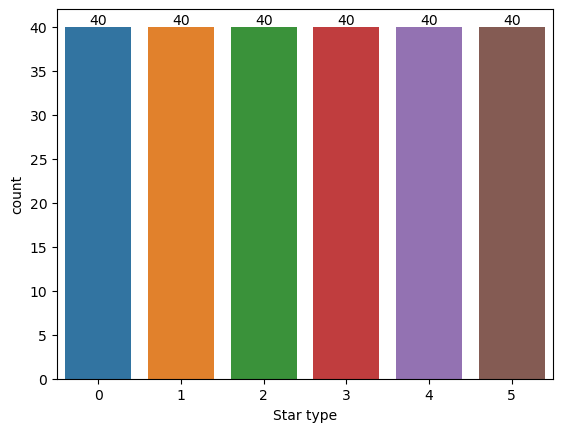

In [8]:
ax = sns.countplot(x='Star type', data=data)
ax.bar_label(ax.containers[0])
plt.show()

Każdego typu gwiazdy jest tyle samo: 40.

Sprawdzimy, czy w naszej tabeli występują braki.

In [9]:
data.isna().sum()

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
Spectral Class            0
dtype: int64

W naszych atrybutach nie ma braków (wartości null).

##### Sprawdziliśmy kolory gwiazd w tabeli:

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Yellowish               1
Orange-Red              1
Blue white              1
Blue-White              1
Name: Star color, dtype: int64


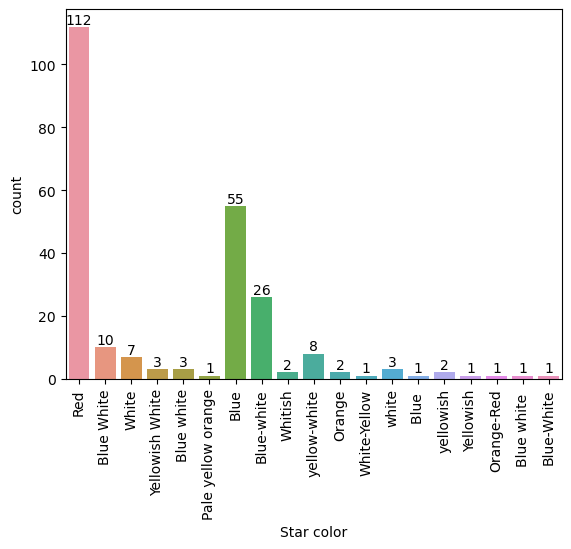

In [10]:
print(data['Star color'].value_counts())

ax = sns.countplot(x='Star color',  data=data)
ax.bar_label(ax.containers[0])

plt.xticks(rotation=90)
plt.show()

Jak widać, niektóre te same kolory zostały od siebie odseparowane z powodu innego zapisu tej samej nazwy. Ujednoliciliśmy ich nazewnictwo:

In [11]:
data.replace({"Star color" : {  "Blue-white" : "Blue-White", 
                                "Blue White" : "Blue-White", 
                                "Blue white" : "Blue-White", 
                                "Blue white " : "Blue-White", 
                                "Blue-White" : "Blue-White",
                                "yellow-white" : "Yellow-White",
                                "Yellowish White" : "Yellow-White",
                                "yellowish" : "Yellow-White",
                                "White-Yellow" : "Yellow-White",
                                "Yellowish" : "Yellow-White",
                                "white" : "White",
                                "Whitish" : "White",
                                "Blue " : "Blue",
                                "Pale yellow orange" : "Red",
                                "Orange" : "Red",
                                "Orange-Red" : "Red"}},
                                inplace = True)

data['Star color'].value_counts()

Red             116
Blue             56
Blue-White       41
Yellow-White     15
White            12
Name: Star color, dtype: int64

Nazewnictwo kolorów zostało ujednolicone. Ich prawidłowe liczbności pokazaliśmy na wykresie:

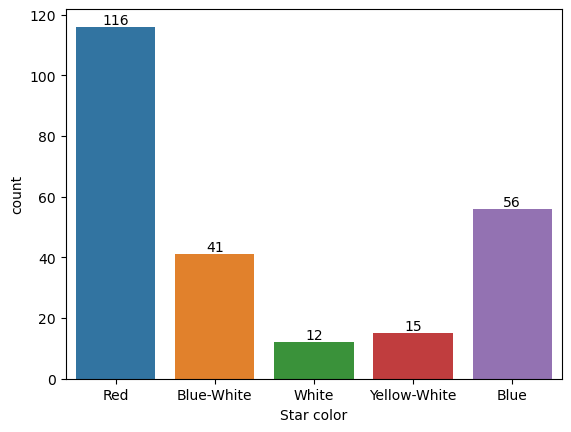

In [12]:
ax = sns.countplot(x='Star color',  data=data)
ax.bar_label(ax.containers[0])

plt.show()

##### Podział gwiazd ze względu na typ widmowy (Spectral Class)

Większość gwiazd jest obecnie rozróżnianych na podstawie systemu Morgana-Keenana. Używa on liter O, B, A, F, G, K oraz M. Wraz z kolejnymi literami obniża się temperatura, czyli oznacza to, że gwiazdy typu O mają największą temperaturę, a typu M mają najniższą.

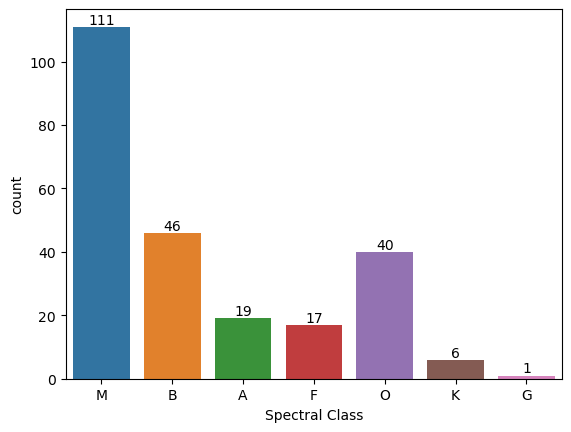

In [13]:
ax = sns.countplot(x='Spectral Class',  data=data)
ax.bar_label(ax.containers[0])

plt.show()

## Diagram Hertzsprunga-Russella

Jest wiele form diagramu Hertzsprunga-Russella. Jednak wszystkie mają podobny zarys: gwiazdy o większej jasności (Luminosity) są u góry wykresy,<br> a gwiazdy z wyższą temperaturą powierzchni (Temperature) są po lewej stronie wykresu.

![image-alt-text](https://upload.wikimedia.org/wikipedia/commons/6/6b/HRDiagram.png)

Przyjętą przez nas formą do reprezentacji przygotowanego zbioru danych będzie diagram, w którym obie osie to skale logarytmiczne. <br>Ten typ diagramu nazywa się **teoretycznym diagramem Hertzsprunga-Russella**.

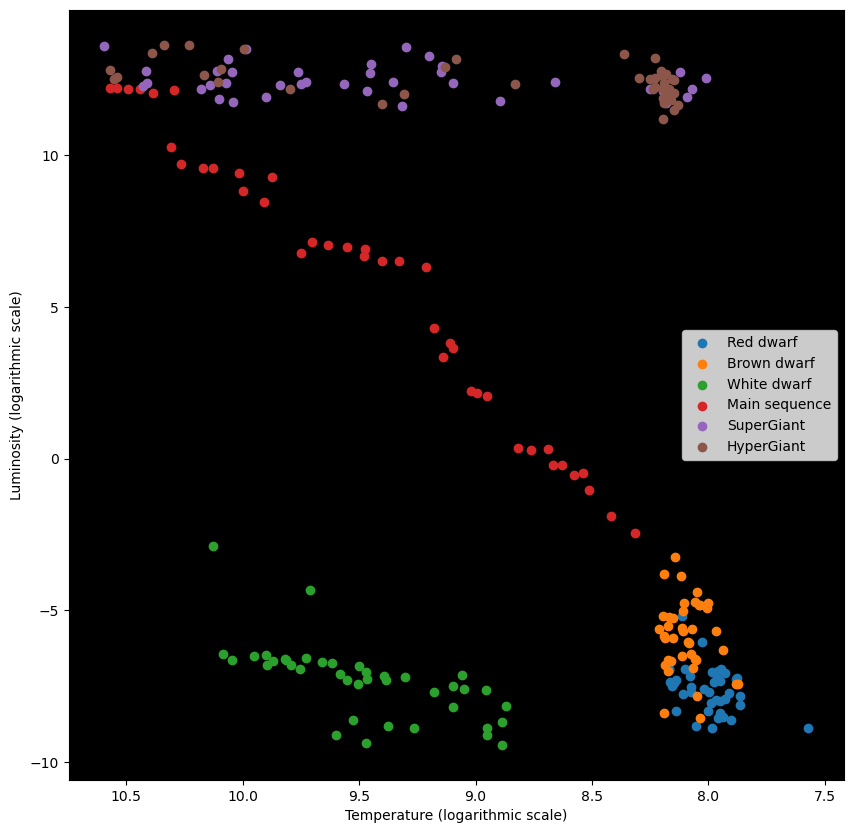

In [14]:
f, x = plt.subplots(figsize = (10,10))

starTypes = ['Red dwarf', 'Brown dwarf', 'White dwarf', 'Main sequence', 'SuperGiant', 'HyperGiant']

for i in data['Star type'].unique():
    x.scatter(np.log(data[data['Star type']==i]['Temperature (K)']), np.log(data[data['Star type']==i]['Luminosity(L/Lo)']), label = starTypes[i])

x.invert_xaxis()
x.legend()
x.set_facecolor('black')

plt.xlabel("Temperature (logarithmic scale)")
plt.ylabel("Luminosity (logarithmic scale)")
plt.grid(False)

Jak widać, na podstawie danych z naszego zbioru również można utworzyć taki diagram. Dostrzec można, że jest on bardzo podobny do tego, który przedstawiliśmy wcześniej.

# Korelacja

Sprawdzimy, które atrybuty mogą być skorelowane (współzależne).

<AxesSubplot:>

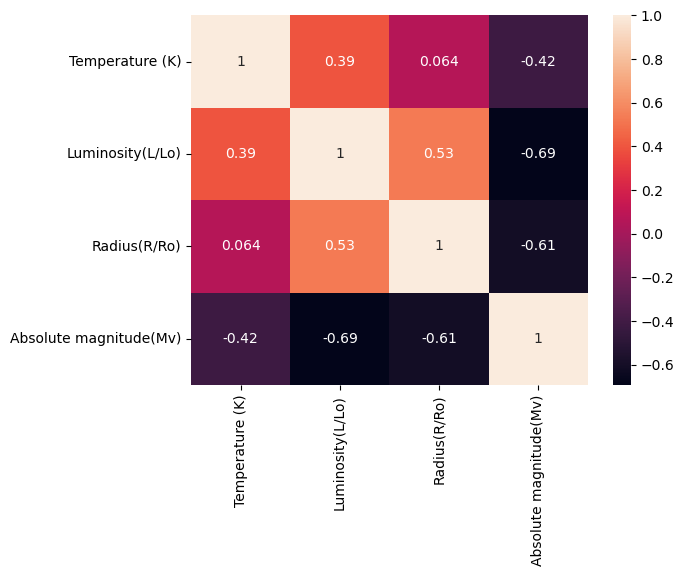

In [15]:
corr = data[['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']].corr()
sns.heatmap(corr, annot = True)

Na podstawie powyższej macierzy korelacji można stwierdzić, że atrybut Absolute Magnitude jest skorelowany ujemnie z każdym z pozostałych atrybutów ilościowych. <br>To właśnie według niego bedziemy sprawdzać, który inny atrybut wybrać do klasyfikacji typów gwiazd. Zwizualizujemy zależność Absolute Magnitude od kolejno Luminosity, Radius oraz Temperature.

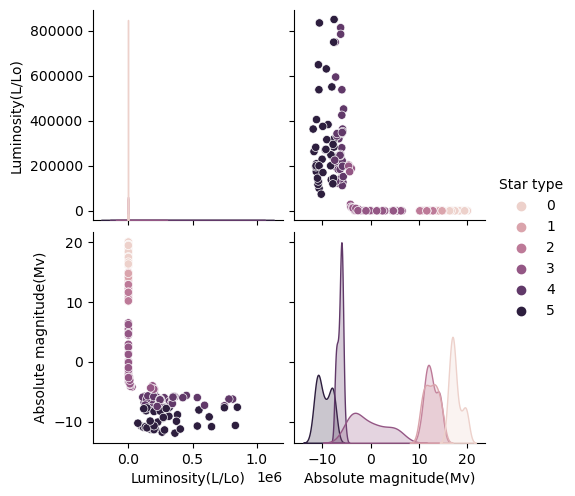

In [16]:
#Wizualizacja rozmieszczenia obiektów ze wzgledu na atrybuty opisujace: 'Luminosity(L/Lo)' i 'Absolute magnitude(Mv)'
#Poszczególne obiekty są etykietowane kolorem, który odpowiada określonemu typowi gwiazdy
lumToMag = data[['Luminosity(L/Lo)', 'Absolute magnitude(Mv)', 'Star type']]
sns.pairplot(lumToMag, kind="scatter", hue = "Star type")
plt.show()

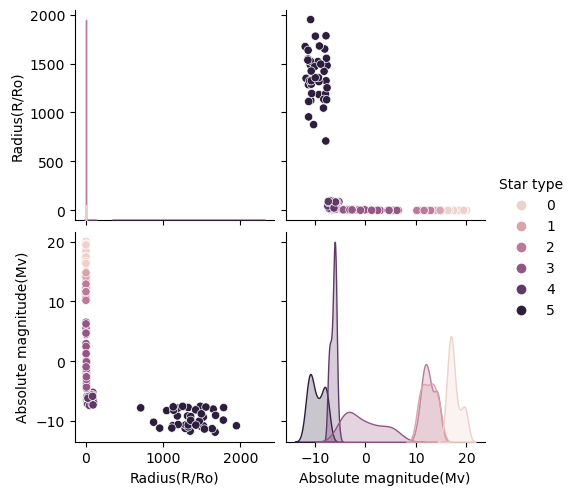

In [17]:
#Wizualizacja rozmieszczenia obiektów ze wzgledu na atrybuty opisujace: 'Radius(R/Ro)' i 'Absolute magnitude(Mv)'
radToMag = data[['Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type']]
sns.pairplot(radToMag, kind="scatter", hue = "Star type")
plt.show()

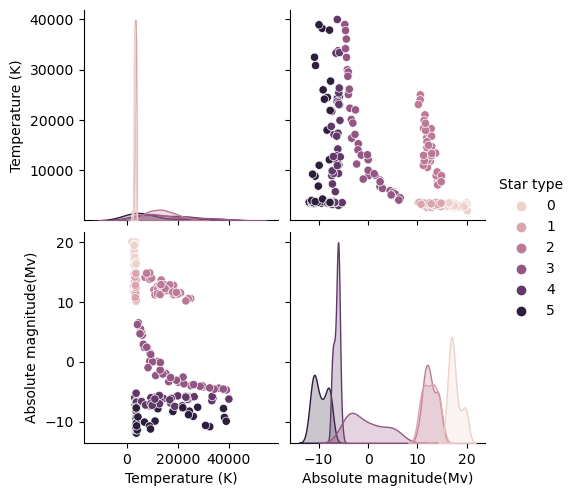

In [18]:
#Wizualizacja rozmieszczenia obiektów ze wzgledu na atrybuty opisujace: 'Temperature (K)' i 'Absolute magnitude(Mv)'
tempToMag = data[['Temperature (K)', 'Absolute magnitude(Mv)', 'Star type']]
sns.pairplot(tempToMag, kind="scatter", hue = "Star type")
plt.show()

Na podstawie powyższej wizualizacji, ustaliliśmy, że do klasyfikacji najlepiej będzie wybrać następujące dwa atrybuty: Absolute Magnitude oraz Temperature.
<br>Jak widać, na wykresie tym można najlepiej odróżnić określony typ gwiazdy, poszczególne obiekty nie są zgrupowane z obiektami o innym typie gwiazdy.

# Klasyfikacja

### Podział na atrybuty opisujące oraz atrybut decyzyjny

In [19]:
# x - atrybuty opisujące
# y - atrybut decyzyjny
x = data[['Temperature (K)', 'Absolute magnitude(Mv)']]
y = data['Star type']

### Standaryzacja danych

In [20]:
x.head()

,Temperature (K),Absolute magnitude(Mv)
0,3068,16.12
1,3042,16.60
2,2600,18.70
3,2800,16.65
4,1939,20.06


In [21]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Star type, dtype: int64

Przekształcając każdy uzyskany w pomiarze wynik poprzez zastosowanie standaryzacji, uzyskaliśmy znormalizowaną miarę. W ten sposób możemy porównywać teraz te dwie miary.

In [22]:
scaler = StandardScaler()
scaledArray = scaler.fit_transform(x)

x = pd.DataFrame(scaledArray)
x.head()

,0,1
0,-0.779382,1.116745
1,-0.782110,1.162414
2,-0.828477,1.362213
3,-0.807496,1.167171
4,-0.897819,1.491607


###### Podział na zbiór uczący i testowy
Podzieliliśmy ten zbiór w stosunku 30% - 70% na odpowiednio zbiór testowy oraz uczący.

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

###### Funkcja pomocnicza do wizualizacji granic klas dla określonego klasyfikatora.

In [24]:
def plot_decision_boundary(clf, X, Y, cmap='gist_rainbow'):
    h = 0.02
    x_min, x_max = X.iloc[:,0].min() - 10*h, X.iloc[:,0].max() + 10*h
    y_min, y_max = X.iloc[:,1].min() - 10*h, X.iloc[:,1].max() + 10*h
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.7)
    plt.scatter(X.iloc[:,0], X.iloc[:,1], c=Y, cmap=cmap, edgecolors='k')

### 1. Klasyfikator najbliższego sąsiada

Dokładność dla zbioru uczącego: 100.00%


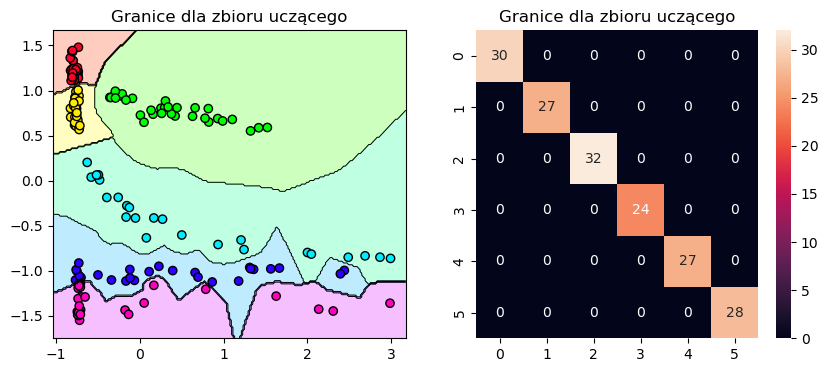

In [25]:
#tworzenie modelu
n_neighbours = 1
nn = KNeighborsClassifier(n_neighbours)
nn.fit(x_train, y_train)

score_train = nn.score(x_train, y_train)
print("Dokładność dla zbioru uczącego: %.2f%%" % (score_train*100))

#wizualizacja granic klas na podstawie klasyfikatora najbliższego sąsiada dla zbioru uczącego
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Granice dla zbioru uczącego")
plot_decision_boundary(nn,x_train,y_train)

y_prediction = nn.predict(x_train)
confusionMatrix = confusion_matrix(y_train, y_prediction)

#wizualizacja macierzy pomyłek dla zbioru uczącego
plt.subplot(1,2,2)
plt.title("Granice dla zbioru uczącego")
sns.heatmap(confusionMatrix, annot=True)

plt.show()

Dokładność dla zbioru testowego: 91.67%


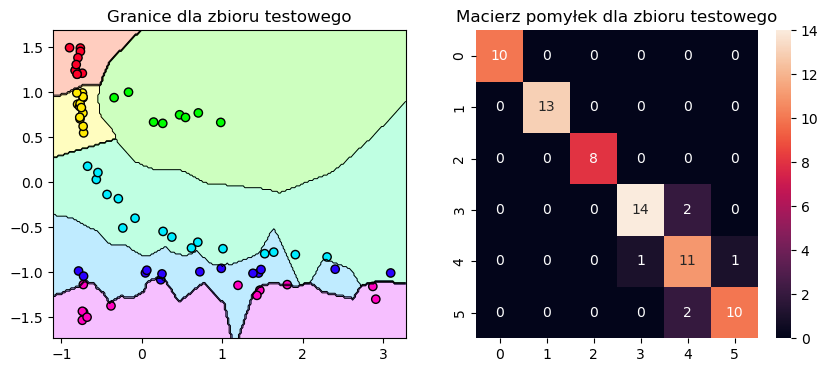

In [26]:
score_test = nn.score(x_test, y_test)
print("Dokładność dla zbioru testowego: %.2f%%" % (score_test*100))

y_prediction = nn.predict(x_test)
confusionMatrix = confusion_matrix(y_test, y_prediction)

#wizualizacja granic klas na podstawie klasyfikatora najbliższego sąsiada dla zbioru testowego
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Granice dla zbioru testowego")
plot_decision_boundary(nn,x_test,y_test)

#wizualizacja macierzy pomyłek dla zbioru testowego
plt.subplot(1,2,2)
plt.title("Macierz pomyłek dla zbioru testowego")
sns.heatmap(confusionMatrix, annot=True)

plt.show()

### 2. Klasyfikator k-najbliższych sąsiadów

Liczbę najbliższych sąsiadów wybierzemy na podstawie wykresu prawdopodobieństwa błędu od liczby sąsiadów:

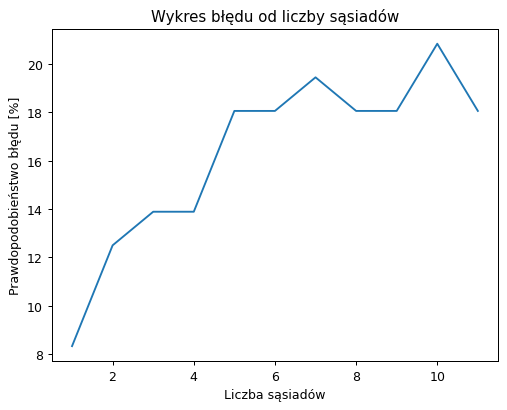

In [27]:
kvals = range(1, 12)
error_chance = np.zeros(11)
for k in kvals:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(x_train,y_train)
    error_chance[k-1] = (1-model.score(x_test,y_test))*100
plt.figure(dpi=90)
plt.plot(kvals, error_chance)
plt.title('Wykres błędu od liczby sąsiadów')
plt.xlabel('Liczba sąsiadów')
plt.ylabel('Prawdopodobieństwo błędu [%]')
plt.show()

Na podstawie powyższego wykresu widać, że najlepszą liczbą sąsiadów jest 3, gdyż jest pierwszą najmniejszą liczbą nieparzystą, która również ma najniższą wartość prawdopodobieństwa popełnienia błędu przy klasyfikacji.<br><br>Pokażemy, jak wyglądałyby granice dla kolejnych nieparzystych liczb sąsiadów:

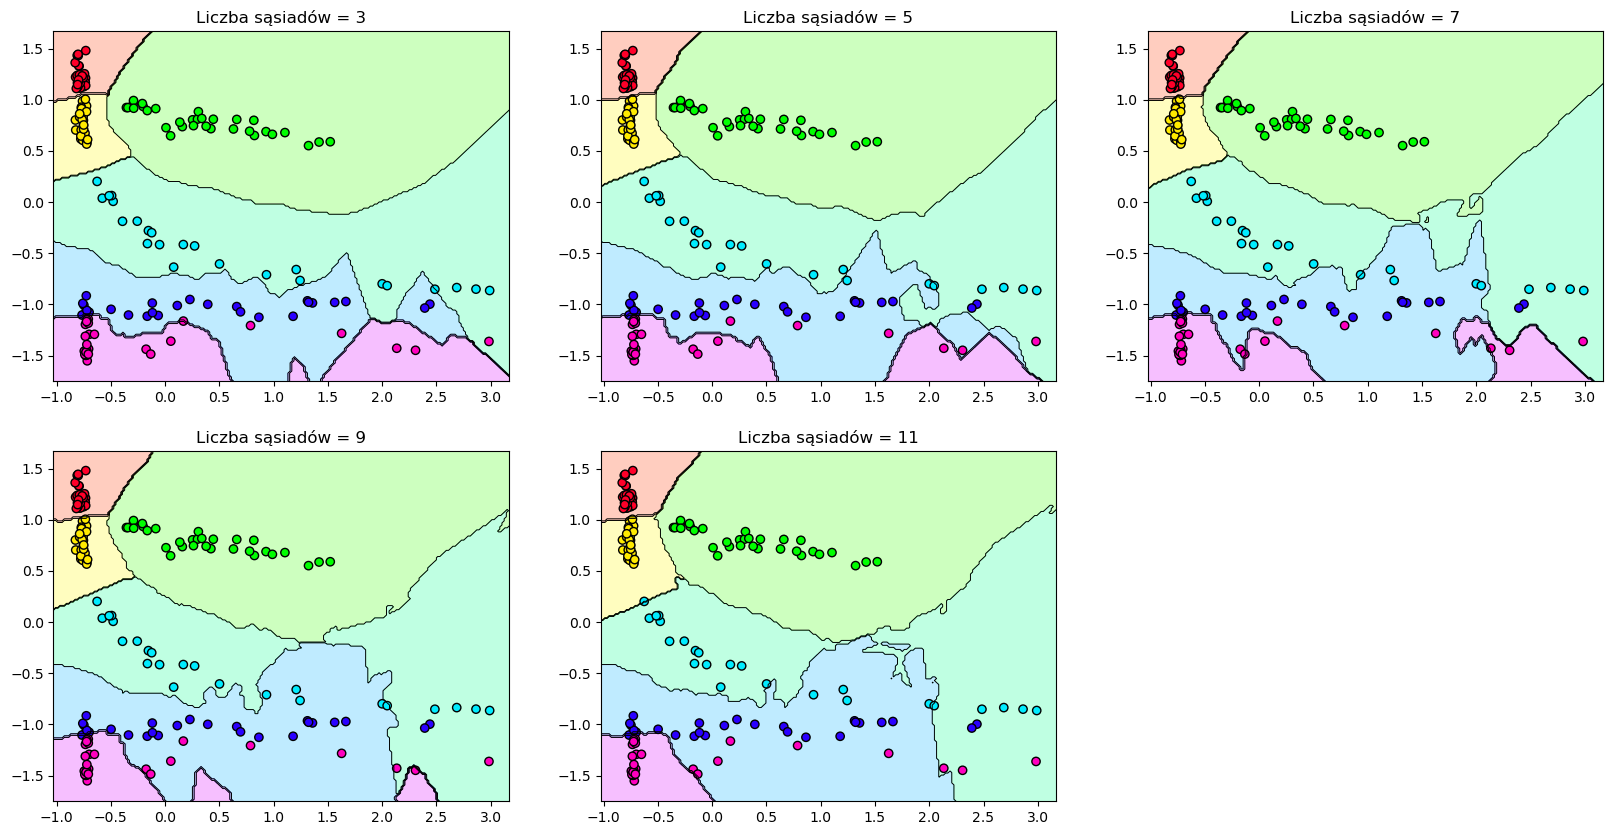

In [28]:
#wykres podzielony na granice klas uzywajac klasyfikatora k najblizszych sąsiadów
x_train.head()
j=1
plt.figure(figsize=(20,10))
for g in [3,5,7,9,11]:
    knn = KNeighborsClassifier(g)
    knn.fit(x_train, y_train)
    plt.subplot(2,3,j)
    plot_decision_boundary(knn,x_train,y_train)
    plt.title("Liczba sąsiadów = " + str(g))
    x_train.head()
    j=j+1

Jak widać, dla poprzednio wyznaczonej liczby sąsiadów (3) wyniki klasyfikacji są najlepsze.

Dokładność dla zbioru uczącego: 97.62%


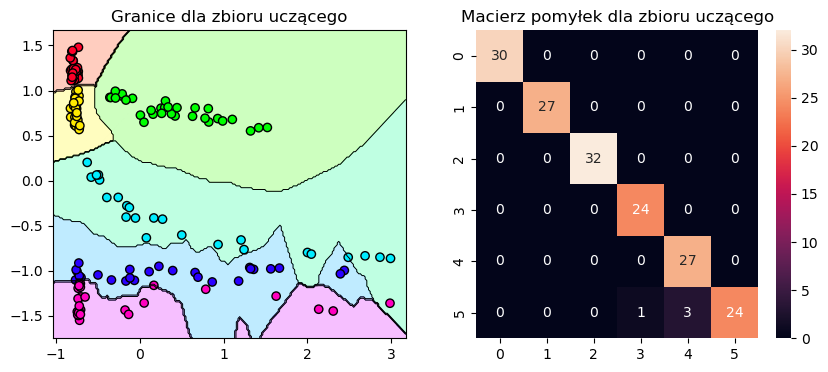

In [29]:
n_neighbours = 3

knn = KNeighborsClassifier(n_neighbours)
knn.fit(x_train, y_train)

score_train = knn.score(x_train, y_train)
print("Dokładność dla zbioru uczącego: %.2f%%" % (score_train*100))

y_prediction = knn.predict(x_train)
confusionMatrix = confusion_matrix(y_train, y_prediction)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Granice dla zbioru uczącego")
plot_decision_boundary(knn,x_train,y_train)

plt.subplot(1,2,2)
sns.heatmap(confusionMatrix, annot=True)
plt.title("Macierz pomyłek dla zbioru uczącego")
plt.show()

Dokładność dla zbioru testowego: 86.11%


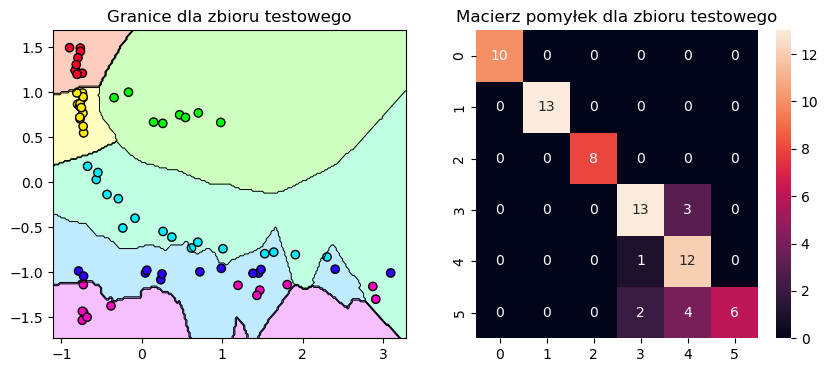

In [30]:
score_test = knn.score(x_test, y_test)
print("Dokładność dla zbioru testowego: %.2f%%" % (score_test*100))

y_prediction = knn.predict(x_test)
confusionMatrix = confusion_matrix(y_test, y_prediction)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Granice dla zbioru testowego")
plot_decision_boundary(knn,x_test,y_test)

plt.subplot(1,2,2)
sns.heatmap(confusionMatrix, annot=True)
plt.title("Macierz pomyłek dla zbioru testowego")
plt.show()

### 3. Metoda najbliższych prototypów

Dokładność dla zbioru uczącego: 75.60%


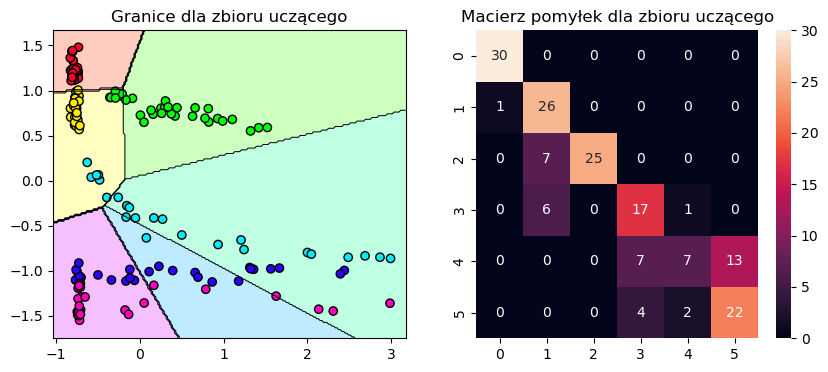

In [31]:
#wykres podzielony na granice klas uzywajac klasyfikatora najblizszych prototypow
nc = NearestCentroid()
nc.fit(x_train, y_train)

score_train = nc.score(x_train, y_train)
print("Dokładność dla zbioru uczącego: %.2f%%" % (score_train*100))

y_prediction = nc.predict(x_train)
confusionMatrix = confusion_matrix(y_train, y_prediction)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Granice dla zbioru uczącego")
plot_decision_boundary(nc,x_train,y_train)


plt.subplot(1,2,2)
sns.heatmap(confusionMatrix, annot=True)
plt.title("Macierz pomyłek dla zbioru uczącego")

plt.show()

Dokładność dla zbioru testowego: 72.22%


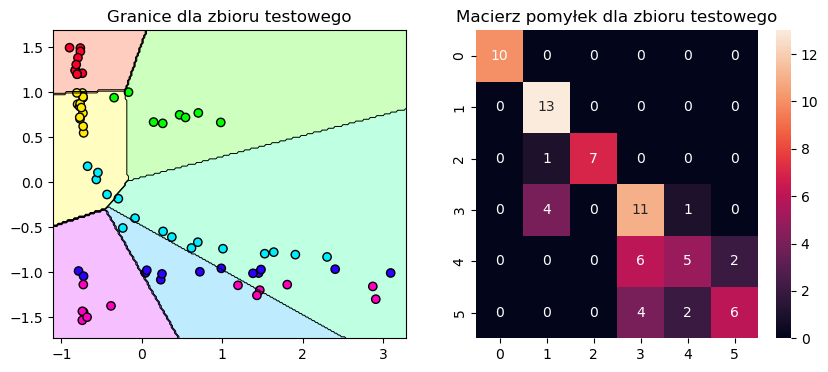

In [32]:
score_test = nc.score(x_test, y_test)
print("Dokładność dla zbioru testowego: %.2f%%" % (score_test*100))

y_prediction = nc.predict(x_test)
confusionMatrix = confusion_matrix(y_test, y_prediction)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Granice dla zbioru testowego")
plot_decision_boundary(nc,x_test,y_test)

plt.subplot(1,2,2)
sns.heatmap(confusionMatrix, annot=True)
plt.title("Macierz pomyłek dla zbioru testowego")

plt.show()

### 4. Naiwny klasyfikator Bayesa (Gaussowski)

Dokładność dla zbioru uczącego: 100.00%


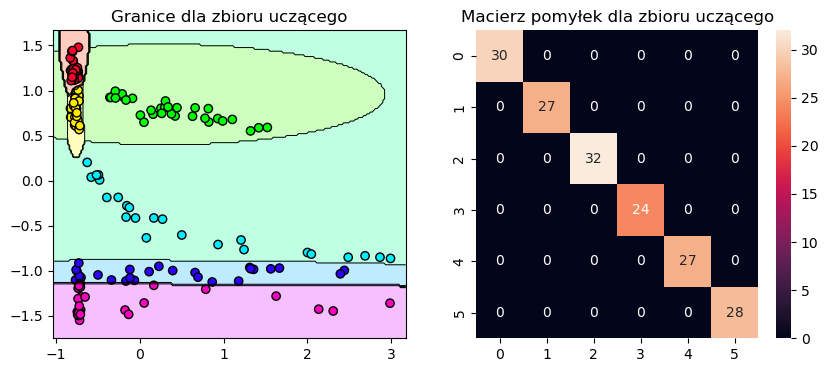

In [33]:
#wykres podzielony na granice klas uzywajac naiwnego klasyfikatora Bayesa
gnb = GaussianNB()
gnb.fit(x_train, y_train)

score_train = gnb.score(x_train, y_train)
print("Dokładność dla zbioru uczącego: %.2f%%" % (score_train*100))

y_prediction = gnb.predict(x_train)
confusionMatrix = confusion_matrix(y_train, y_prediction)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Granice dla zbioru uczącego")
plot_decision_boundary(gnb,x_train,y_train)

plt.subplot(1,2,2)
sns.heatmap(confusionMatrix, annot=True)
plt.title("Macierz pomyłek dla zbioru uczącego")

plt.show()

Dokładność dla zbioru testowego: 93.06%


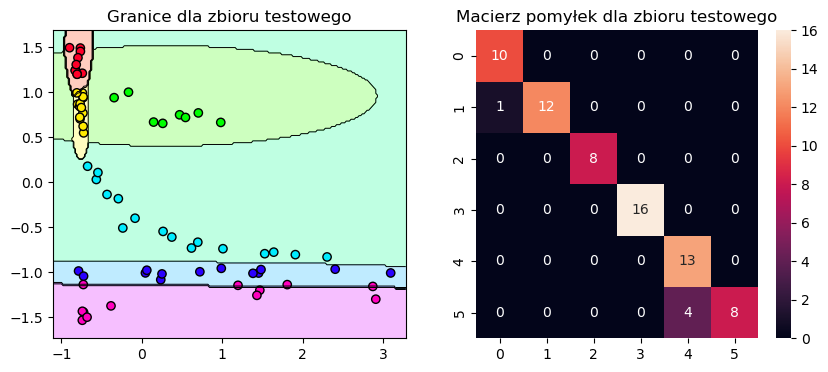

In [34]:
score_test = gnb.score(x_test, y_test)
print("Dokładność dla zbioru testowego: %.2f%%" % (score_test*100))

y_prediction = gnb.predict(x_test)
confusionMatrix = confusion_matrix(y_test, y_prediction)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Granice dla zbioru testowego")
plot_decision_boundary(gnb,x_test,y_test)

plt.subplot(1,2,2)
sns.heatmap(confusionMatrix, annot=True)
plt.title("Macierz pomyłek dla zbioru testowego")
plt.show()

### 5. Drzewo decyzyjne

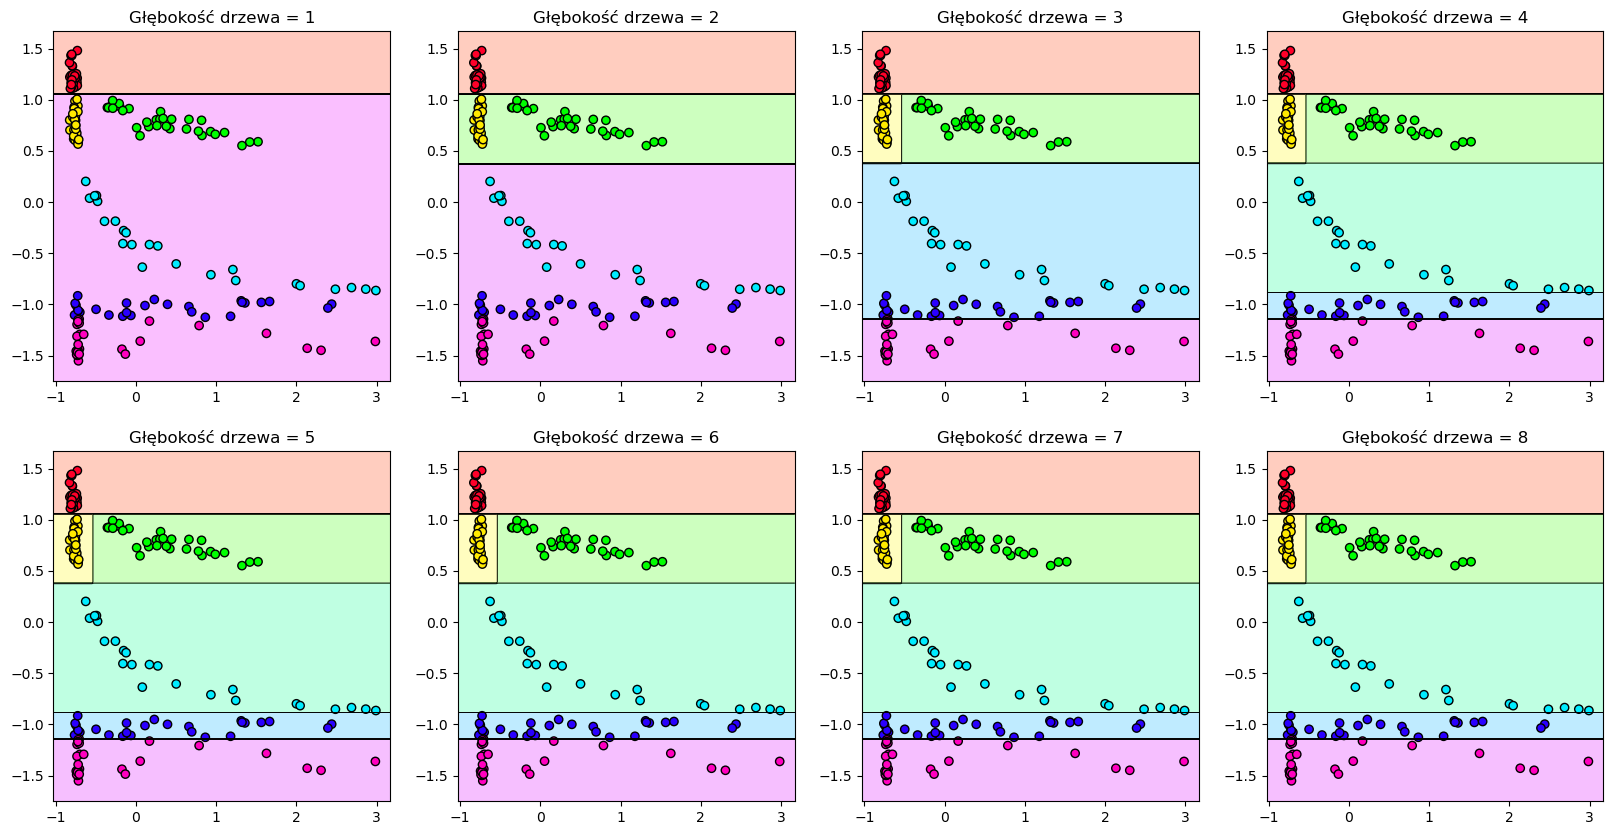

In [35]:
#wykres podzielony na granice dla drzew o maksymalnej głebokości kolejno: 1,2,3,4,5,6,7,8
j = 1
plt.figure(figsize=(20,10))
for g in [1,2,3,4,5,6,7,8]:
    drzewo = tree.DecisionTreeClassifier(max_depth=g)
    drzewo.fit(x_train, y_train)
    plt.subplot(2,4,j)
    plot_decision_boundary(drzewo,x_train,y_train)
    plt.title("Głębokość drzewa = " + str(g))
    x_train.head()
    j = j+1

Jak widać, najlepszy podział zachodzi już dla głębokości drzewa równej 4. Dlatego też takiej wartości użyjemy w dalszej części.

Dokładność dla zbioru uczącego: 100.00%


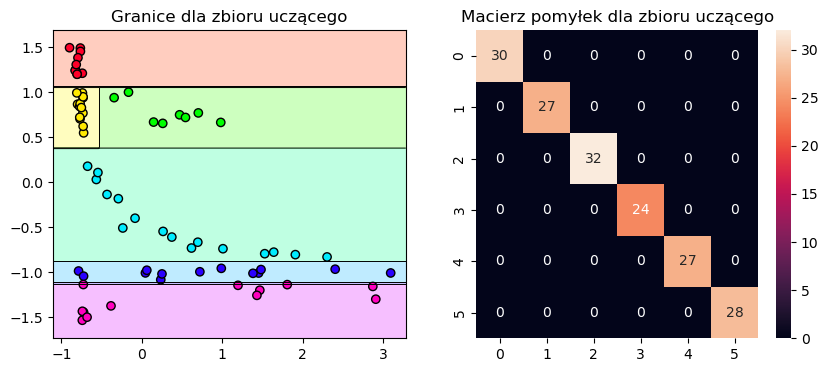

In [36]:
tree = tree.DecisionTreeClassifier(max_depth=4)
tree.fit(x_train, y_train)

score_train = tree.score(x_train, y_train)
print("Dokładność dla zbioru uczącego: %.2f%%" % (score_train*100))

y_prediction = tree.predict(x_train)
confusionMatrix = confusion_matrix(y_train, y_prediction)


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Granice dla zbioru uczącego")
plot_decision_boundary(tree,x_test,y_test)

plt.subplot(1,2,2)
sns.heatmap(confusionMatrix, annot=True)
plt.title("Macierz pomyłek dla zbioru uczącego")
plt.show()

Dokładność dla zbioru testowego: 100.00%


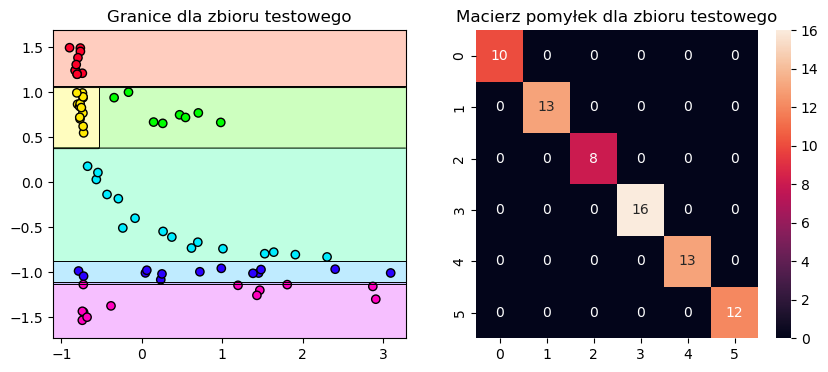

In [37]:
score_test = tree.score(x_test, y_test)
print("Dokładność dla zbioru testowego: %.2f%%" % (score_test*100))

y_prediction = tree.predict(x_test)
confusionMatrix = confusion_matrix(y_test, y_prediction)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Granice dla zbioru testowego")
plot_decision_boundary(tree,x_test,y_test)

plt.subplot(1,2,2)
sns.heatmap(confusionMatrix, annot=True)
plt.title("Macierz pomyłek dla zbioru testowego")
plt.show()

# Wnioski

Przeprowadziliśmy klasyfikację z użyciem pięciu różnych sposobów: metodą najbliższego sąsiada, metodą k-najbliższych sąsiadów (w naszym przypadku liczba sąsiadów wyniosła 3), metodą nabliższego prototypu, z pomocą naiwny klasyfikator Bayesa, a także drzewa decyzyjnego (o głębokości równej 4). Dla każdego uzyskaliśmy dokładności dla odpowiednio zbioru uczącego i zbioru testowego, a także zwizualizowaliśmy granicę klas oraz macierze pomyłek dla tych zbiorów.
- Do klasyfikacji tego zbioru najlepszymi atrybutami są Absolute Magnitude oraz Temperature, gdyż na wykresie zależności tych dwóch cech poszczególne obiekty nie są zgrupowane z obiektami o innym typie gwiazdy
- Najgorszy rezultat uzyskaliśmy przy użyciu metody najbliższego prototypu. Dla tego klasyfikatora uzyskaliśmy najmniejszą dokładność dla zbioru uczącego (75.60%), a także dla testowego (72.22%).
- Uzyskaliśmy trzy dokładności równe 100% dla zbiorów uczących dla: metody najbliższego sąsiada, naiwnego klasyfikatora Bayesa oraz drzewa decyzyjnego.
- Dla trzech powyższych sposobów, najgorszy rezultat dla zbioru testowego uzykaliśmy dla metody najbliższego sąsiada (91.67%), następnie dla naiwnego klasyfikatora Bayesa (93.06%), za to dla drzewa decyzyjnego otrzymaliśmy dokładność zbioru testowego równą 100%.
- Można dojść do wniosku, że najlepszym modelem dla naszego zbioru jest drzewo decyzyjne o głębokości 4.
- Dla tak niewielkiego zbioru danych (240 obiektów) czasy działania poszczególnych metod klasyfikacyjnych były porównywalne.
- Uważamy, że klasyfikację z użyciem drzewa decyzyjnego można by zastosować w realnym badaniu, gdybyśmy znali wybrane przez nas atrybuty.